# Waymo Open Dataset E2ED Visualization

This notebook visualizes all camera images, ego vehicle intent, sequence number, and index number from the Waymo Open Dataset End-to-End Driving (E2ED) data. It projects past trajectory states onto back cameras (side_left, side_right, rear, rear_left, rear_right) and future states onto front cameras (front, front_left, front_right). It also creates a top-down (bird's-eye) view and stitches the front 5 cameras (front, front_left, front_right, side_left, side_right) and back 3 cameras (rear, rear_left, rear_right) into composite images.

**Dataset Details**:
- Visualizes all cameras: front (1), front_left (2), front_right (3), side_left (4), side_right (5), rear_left (6), rear (7), rear_right (8).
- Past states (t = -4s to 0s) are shown on back cameras; future states (t = 0s to 5s) on front cameras.
- Stitched views: Front 5 cameras and back 3 cameras are concatenated horizontally; top-down view combines all cameras.

## Package Installation

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import cv2
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.wdl_limited.camera.ops import py_camera_model_ops
from waymo_open_dataset.protos import end_to_end_driving_data_pb2 as wod_e2ed_pb2

2025-04-24 23:09:05.087979: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 23:09:05.089539: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 23:09:05.122641: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-24 23:09:05.123290: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 23:09:06.548190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Loading the Data

In [12]:
# Set environment variables for authentication
os.environ['CURL_CA_BUNDLE'] = '/home/aaylen/Documents/Waymo-Challenge/cacert.pem'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/aaylen/Documents/Waymo-Challenge/token1.json'

# Define dataset path
DATASET_FOLDER = 'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0'
TRAIN_FILES = os.path.join(DATASET_FOLDER, '*.tfrecord-*')

# Initialize dataset
filenames = tf.io.matching_files(TRAIN_FILES)
dataset = tf.data.TFRecordDataset(filenames, compression_type='')
dataset_iter = dataset.as_numpy_iterator()

# Retrieve one example (targeting the specified frame)
target_frame_name = 'b197472f28df9f18c22654a5b514082a-072'
data = None
for bytes_example in dataset_iter:
    frame_data = wod_e2ed_pb2.E2EDFrame()
    frame_data.ParseFromString(bytes_example)
    print(frame_data.frame.context.name)
    if frame_data.frame.context.name == target_frame_name:
        data = frame_data
        break

2025-04-24 23:31:17.149570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [315]
	 [[{{node Placeholder/_0}}]]


d6cdf6eb1b7d4a8be6dac71f34e6cdb7-164
b197472f28df9f18c22654a5b514082a-072


## Visualization Functions

In [13]:
def get_all_cameras(data: wod_e2ed_pb2.E2EDFrame):
    """Return all 8 camera images and calibrations."""
    image_list = []
    calibration_list = []
    camera_names = {
        1: 'FRONT',
        2: 'FRONT_LEFT',
        3: 'FRONT_RIGHT',
        4: 'SIDE_LEFT',
        5: 'SIDE_RIGHT',
        6: 'REAR_LEFT',
        7: 'REAR',
        8: 'REAR_RIGHT'
    }
    order = [1, 2, 3, 4, 5, 6, 7, 8]
    
    for camera_name in order:
        for index, image_content in enumerate(data.frame.images):
            if image_content.name == camera_name:
                calibration = data.frame.context.camera_calibrations[index]
                image = tf.io.decode_image(image_content.image).numpy()
                image_list.append((camera_names[camera_name], image))
                calibration_list.append((camera_names[camera_name], calibration))
                break
    
    return image_list, calibration_list

def project_vehicle_to_image(vehicle_pose, calibration, points):
    """Projects from vehicle coordinate system to image with global shutter."""
    pose_matrix = np.array(vehicle_pose.transform).reshape(4, 4)
    world_points = np.zeros_like(points)
    for i, point in enumerate(points):
        cx, cy, cz, _ = np.matmul(pose_matrix, [*point, 1])
        world_points[i] = (cx, cy, cz)

    extrinsic = tf.reshape(
        tf.constant(list(calibration.extrinsic.transform), dtype=tf.float32), [4, 4])
    intrinsic = tf.constant(list(calibration.intrinsic), dtype=tf.float32)
    metadata = tf.constant([
        calibration.width,
        calibration.height,
        open_dataset.CameraCalibration.GLOBAL_SHUTTER,
    ], dtype=tf.int32)
    camera_image_metadata = list(vehicle_pose.transform) + [0.0] * 10

    return py_camera_model_ops.world_to_image(
        extrinsic, intrinsic, metadata, camera_image_metadata, world_points).numpy()

def draw_points_on_image(image, points, size, color=(255, 0, 0)):
    """Draws points on an image."""
    image_copy = image.copy()
    for point in points:
        if point[2] > 0:  # Check if point is valid (ok flag)
            cv2.circle(image_copy, (int(point[0]), int(point[1])), size, color, -1)
    return image_copy

def stitch_front_cameras(images, calibrations, future_waypoints, vehicle_pose, downsample_size=(640, 480)):
    """Stitch front 5 cameras (SIDE_LEFT, FRONT_LEFT, FRONT, FRONT_RIGHT, SIDE_RIGHT) with future trajectories."""
    front_cameras = ['SIDE_LEFT', 'FRONT_LEFT', 'FRONT', 'FRONT_RIGHT', 'SIDE_RIGHT']  # Desired order
    front_images = []
    max_height = 0
    
    for camera_name in front_cameras:  # Iterate in specified order
        for name, image in images:
            if name == camera_name:
                image = cv2.resize(image, downsample_size)  # Downsample for performance
                calibration = next(calib for n, calib in calibrations if n == camera_name)
                waypoints_camera_space = project_vehicle_to_image(vehicle_pose, calibration, future_waypoints)
                image_with_points = draw_points_on_image(image, waypoints_camera_space, size=15, color=(255, 0, 0))
                front_images.append(image_with_points)
                max_height = max(max_height, image.shape[0])
                break
    
    # Resize images to the same height for concatenation
    resized_images = []
    for img in front_images:
        if img.shape[0] != max_height:
            scale = max_height / img.shape[0]
            new_width = int(img.shape[1] * scale)
            img = cv2.resize(img, (new_width, max_height))
        resized_images.append(img)
    
    return np.concatenate(resized_images, axis=1)

def stitch_back_cameras(images, calibrations, past_waypoints, vehicle_pose):
    """Stitch back 3 cameras (REAR, REAR_LEFT, REAR_RIGHT) with past trajectories."""
    back_cameras = ['REAR_LEFT','REAR', 'REAR_RIGHT']
    back_images = []
    max_height = 0
    
    for camera_name in back_cameras:
        for name, image in images:
            if name == camera_name:
                calibration = next(calib for name, calib in calibrations if name == camera_name)
                waypoints_camera_space = project_vehicle_to_image(vehicle_pose, calibration, past_waypoints)
                image_with_points = draw_points_on_image(image, waypoints_camera_space, size=15, color=(0, 255, 0))
                back_images.append(image_with_points)
                max_height = max(max_height, image.shape[0])
    
    # Resize images to the same height for concatenation
    resized_images = []
    for img in back_images:
        if img.shape[0] != max_height:
            scale = max_height / img.shape[0]
            new_width = int(img.shape[1] * scale)
            img = cv2.resize(img, (new_width, max_height))
        resized_images.append(img)
    
    return np.concatenate(resized_images, axis=1)

## Visualize All Cameras with Trajectories and Metadata

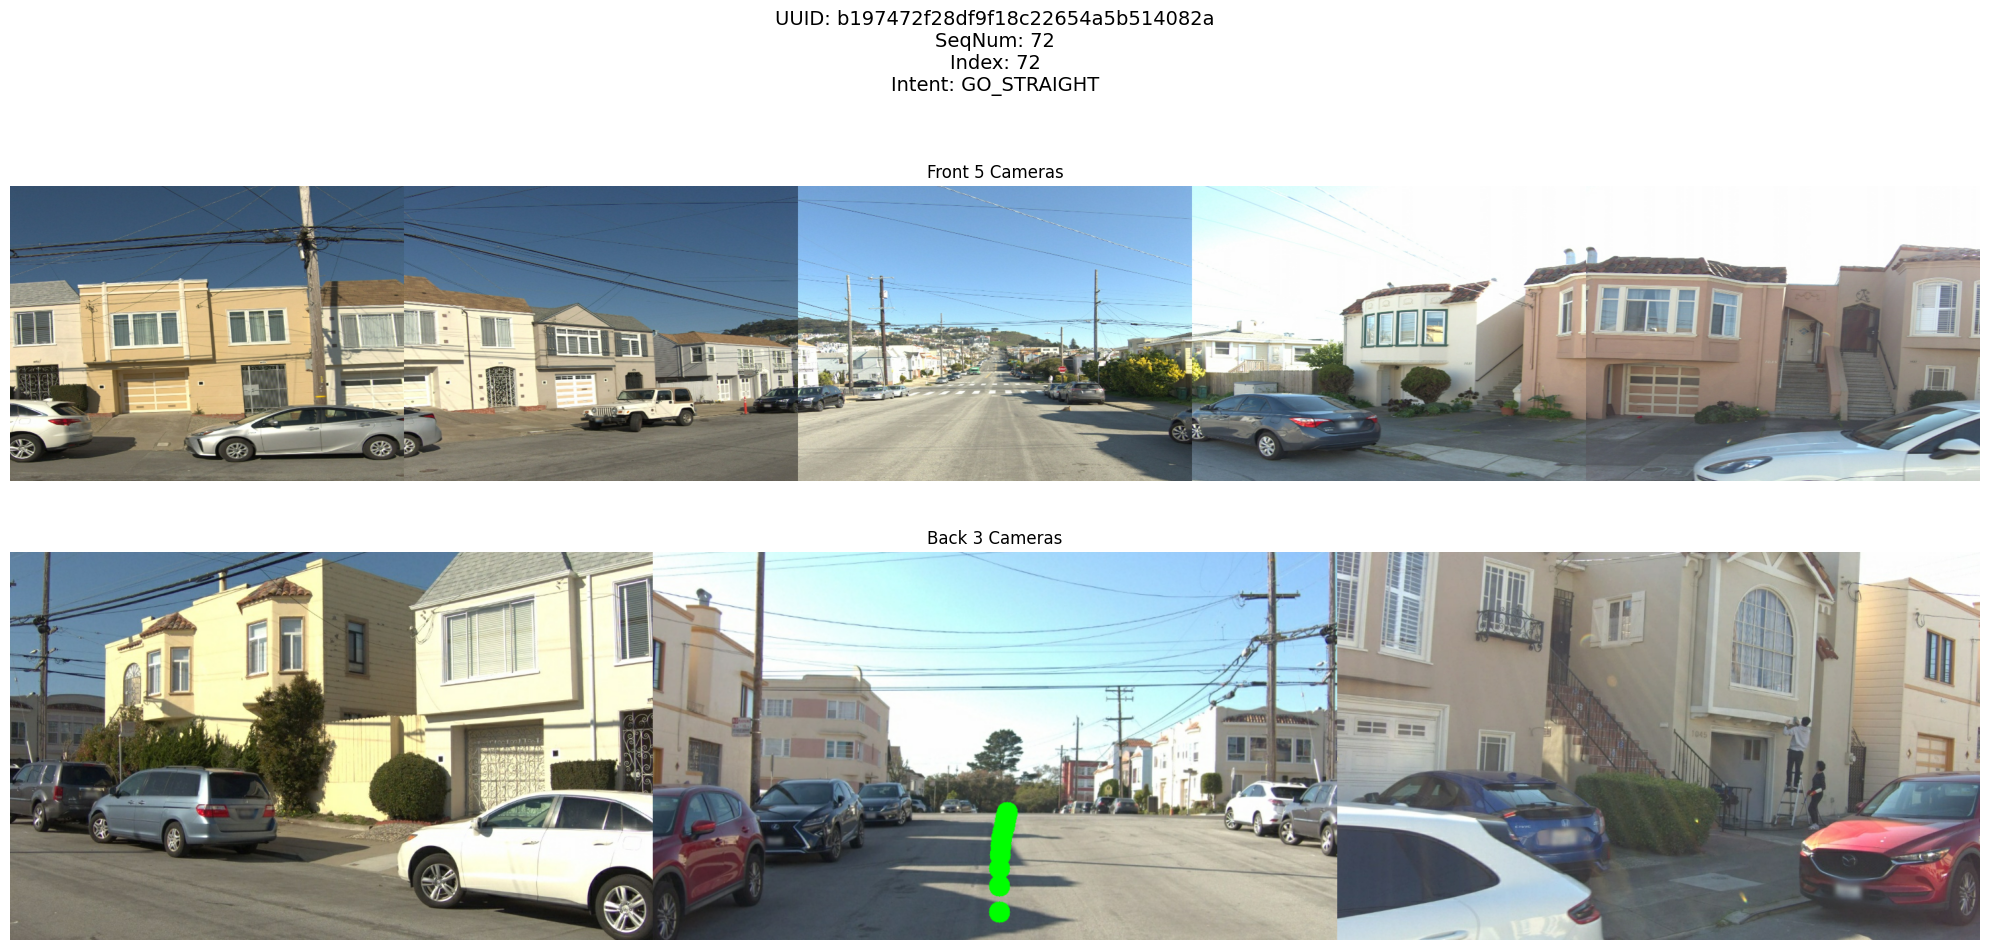

In [32]:
all_camera_images, all_camera_calibrations = get_all_cameras(data)

# Extract past and future trajectories
past_waypoints = np.stack([data.past_states.pos_x, data.past_states.pos_y, np.zeros_like(data.past_states.pos_x)], axis=1)
future_waypoints = np.stack([data.future_states.pos_x, data.future_states.pos_y, data.future_states.pos_z], axis=1)

# Get vehicle pose
vehicle_pose = data.frame.images[0].pose

# Prepare individual camera images with trajectories
images_with_points = []
camera_names = [name for name, _ in all_camera_images]
for i, (camera_name, image) in enumerate(all_camera_images):
    calibration = next(calib for name, calib in all_camera_calibrations if name == camera_name)
    if camera_name in ['SIDE_LEFT', 'SIDE_RIGHT', 'REAR', 'REAR_LEFT', 'REAR_RIGHT']:
        waypoints_camera_space = project_vehicle_to_image(vehicle_pose, calibration, past_waypoints)
        image_with_points = draw_points_on_image(image, waypoints_camera_space, size=15, color=(0, 255, 0))
    elif camera_name in ['FRONT', 'FRONT_LEFT', 'FRONT_RIGHT','SIDE_LEFT', 'SIDE_RIGHT']:
        waypoints_camera_space = project_vehicle_to_image(vehicle_pose, calibration, future_waypoints)
        image_with_points = draw_points_on_image(image, waypoints_camera_space, size=15, color=(255, 0, 0))
    else:
        image_with_points = image.copy()
    images_with_points.append((camera_name, image_with_points))

# Create front and back stitched views
front_stitched_image = stitch_front_cameras(all_camera_images, all_camera_calibrations, future_waypoints, vehicle_pose)
back_stitched_image = stitch_back_cameras(all_camera_images, all_camera_calibrations, past_waypoints, vehicle_pose)

# Extract metadata
frame_name = data.frame.context.name
uuid, seq_num = frame_name.rsplit('-', 1)
seq_num = int(seq_num)
intent = wod_e2ed_pb2.EgoIntent.Intent.Name(data.intent)
index_num = seq_num

# Visualize
fig = plt.figure(figsize=(20, 10))

# Front stitched view
ax = fig.add_subplot(2, 1, 1)
ax.imshow(front_stitched_image)
ax.set_title('Front 5 Cameras')
ax.axis('off')

# Back stitched view
ax = fig.add_subplot(2, 1, 2)
ax.imshow(back_stitched_image)
ax.set_title('Back 3 Cameras')
ax.axis('off')

plt.suptitle(f'UUID: {uuid}\nSeqNum: {seq_num}\nIndex: {index_num}\nIntent: {intent}', fontsize=14)
plt.tight_layout(rect=[0,0,1, 1])
plt.show()